# <strong>Метрики в задачах классификации</strong>







Сейчас мы рассмотрим метрики в задачах классификации. 
Для обучения возьмём уже существующий классификатор на основе метода стохастического градиентного спуска (SGD - Stohastic
Gradient Descent) класс SGDClassifier из библиотеки Scikit-Learn. 
Причина почему мы используем данный классификатор - его эффективность на при обработке очень крупных наборов данных. 
Связано это в основном с тем, что SGD использует обучающие образцы один раз независимым образом.
Далее создадим экземпляр SGDClassifier и обучим его на целом имеющемся у нас обучающем наборе. Этот класс полагается на неупорядоченность во время обучения, что соответствует значению слова "стохастический".
Стохастический - случайный, вероятностный, беспорядочный, непредсказуемый.
На его примере мы рассмотрим матрицу неточностей, точность, полноту и другие метрики.

# <strong>Матрица неточностей</strong>

Достаточно неплохой способ оценки эффективности классификатора предусматривает просмотр матрицы неточностей (confusion matrix). Суть заключается в том, чтобы подсчитать, сколько раз элемент относящийся к классу А был по ошибке отнесён к классу В. Например, классификатор путал "шестёрки" с "пятерками", то есть, по ошибке относил 6 к классу 5, чтобы узнать сколько раз такое происходило, стоит лишь посмотреть в шестую строку пятый столбец матрицы неточностей.
Чтобы рассчитать матрицу неточностей, нужно иметь какой-то набор прогнозов, который можно сопоставлять с фактическими целями. Конечно же можно выработать прогнозы на испытатательном наборе, но давайте не будем его трогать и применим его в самом конце на готовом классификаторе. Поэтому, используем функцию cross_val_predict().

Функция cross_val_predict() практически аналогична cross_val_score(), то есть выполняет перекрестную проверку по К блокам, только вместо сумм очков оценки возвращает предсказания, выработанные на каждом испытательном блоке. В результате, получим прогноз для каждого образца, сделанный моделью, которая никогда не видела данные во время обучения, то есть, так называемый "чистый" прогноз.

Теперь мы можем получить матрицу неточностей, используя функцию conflusion_matrix(), передавая ей целевые классы y_train_3 и спрогнозированные функцией cross_val_predict(), то есть, y_train_pred:

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3) # True для всех троек, False для всех остальных цифр. задача: опознать тройки
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) # классификатор на основе метода стохастического градиентного спуска (англ. Stochastic Gradient Descent SGD)
sgd_clf.fit(X_train, y_train_3) # обучаем классификатор распозновать тройки на целом обучающем наборе
# Для расчета матрицы ошибок сначала понадобится иметь набор прогнозов, чтобы их можно было сравнивать с фактическими целями
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
print(confusion_matrix(y_train_3, y_train_pred))
# что должно у вас получиться:
# array([[53477, 392],
#        [ 2113, 4018]])

[[53477   392]
 [ 2113  4018]]


Итак, поздравляю, мы получили матрицу неточностей! В полученной в выводе программы матрицы каждая строка представляет собой фактический класс, а каждый столбец спрогнозированный класс. В первой строке,которая учитывает изображения "не троек", в первом столбце можно увидеть число 53477, что соответствует числу правильно классифицированных "не троек" **(True Negative)**, а число, расположенное во втором столбце первой строки (392) соответствует числу ошибочно классифицированных "не троек", то есть, цифр, отнесенных к классу "троек", но не являющихся "тройками" **(False Positive)**.
Вторая строка соответствует классу "троек", поэтому в первом столбце число 2113 означает число "троек", отнесенных по ошибке к другим классам (не троек) **(False Negative)**, а во втором столбце 4018 - число правильно классифицированных "троек" **(True Positive)**.

Для полной наглядности, реализуем "идальный" классификатор, работающий с точностью 100%, как видно в выводе кода ниже, ненулевые значения находятся только на главной диагонали матрицы неточностей. В ней отсутствуют неправильно классифицированные цифры, поэтому на побочной диагонали вы можете лицезреть два "0".

In [3]:
y_train_pred = y_train_3
print(confusion_matrix(y_train_3, y_train_pred))

[[53869     0]
 [    0  6131]]


Из матрицы неточностей можно получить много информации, однако, иногда можно использовать более сжатую метрику, одной из таких метрик является аккуратность положительных классификаций, что называется precision, то есть, точность классификатора.

# <strong>Точность (precision)</strong>

Рассмотрим уравнение точности (precision):

### <strong>$precision =\frac{TP}{(TP+FP)}$</strong>

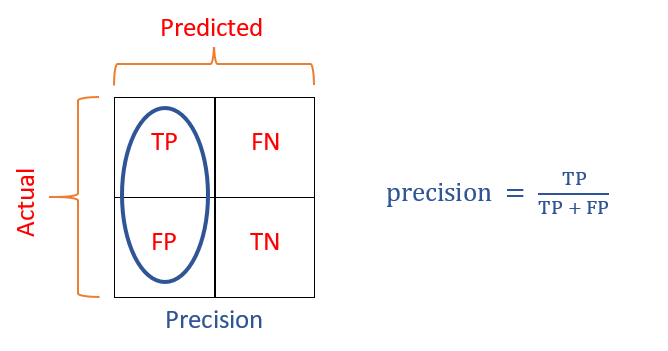

Где TP - true positive, то есть, количество истинно положительных классификаций, а FP - false positive, количество ложно положительных классификаций. Простым языком, TP - это количество объектов действительно принадлежащих к классу, к которому их отнесли, а FP - количество объектов, которых отнесли к данного классу по ошибке, то есть, получаем, что точность это  доля объектов действительно принадлежащих данному классу относительно всех объектов которые система отнесла к этому классу (отношение количества правильно отнесенных к классу объектов к всем объектам, которые были отнесены к данному классу).

Однако, стоит отметить, что если будет правильно классифицирован лишь один объект и больше ничего не будет отнесено к данному классу, то точность в таком случае будет 100% (например, к классу "четверок" была отнесена лишь 1 четверка, и больше ничего, остальные цифры по ошибке беспорядочно распределились по остальным кклассам), поэтому вместе с точностью (precision) обычно используют ещё одну метрику полнота (recall), к рассмотрению которой перейдем сейчас.

In [28]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3) 
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_3) 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
print(precision_score(y_train_3, y_train_pred)) 

0.9111111111111111


# <strong>Полнота (recall)</strong>

### <strong>$recall =\frac{TP}{(TP+FN)}$</strong>


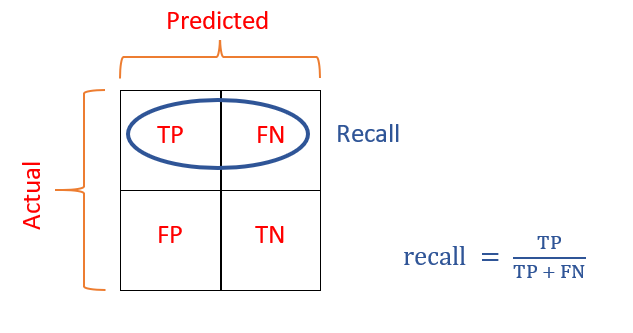


В данном уравнении в числителе всё также количество истинно положительных классификаций, а в знаменатель отличается от уравнения precision вторым слагаемым в сумме, которое является FN - false negative, то есть, количество ложно отрицательных классификаций

In [5]:
 print(recall_score(y_train_3, y_train_pred)) 

0.655358016636764


Чтобы подвести некий промежуточный итог, отметим, что точность нашего классиикатора (precision) составляет 91%, это означает, что среди всех чисел, отнесенных к классу "троек" 91%, самих собственно "троек". Чего нельзя сказать о полноте (recall), ведь наш классификатор определил к правильному классу только 65% "троек", что соответствует выводу функции recall_score(). 




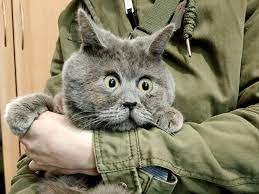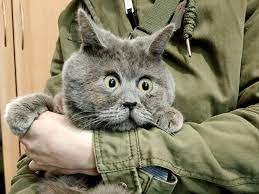


# <strong>Уравнение 3 Мера F1 (F1 score)</strong>


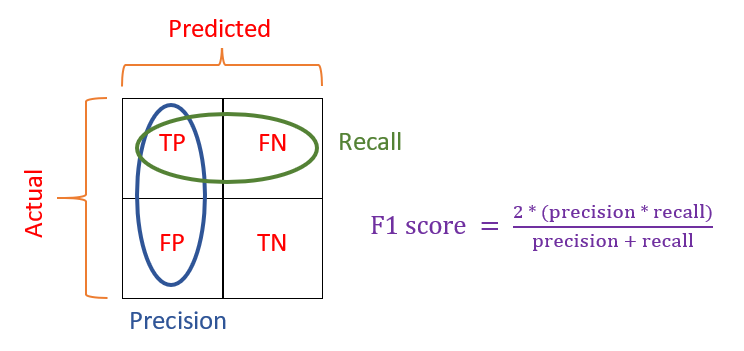

Иногда удобно объединять точность и полноту в одну метрику - F1 score, которая представляет собой среднее гармоническое точности и полноты (precision and recall). Отличие F1 score от обычного среднего заключается в том, что простое среднее придает одинаковый вес всем значениям выборки, в то время как среднее гармоническое (F1 score) придает более низким значениям больший вес. В результате показатель F1 score будет высоким тогда, когда высокими будут и точность и полнота. 
Расчёт данной метрики демонстрируется в коде ниже. Для вычисления F1 - меры достаточно просто вызвать функцию f1_score():
    

In [18]:
 # код для подсчета метрики F-мера:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3) 
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_3)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
print(f1_score(y_train_3, y_train_pred))

0.7623565126648326


F1 мера поддерживает классификаторы, которые имеют подобные полноту и точность. Но иногда это не то, что требуется в конкретной ситуации, например, в некоторых ситуациях более важной метрикой является полнота, а в других ситуациях наоборот приходится заботиться о точности. Например, если вы выявляете классификатор выявлять статьи, безопасные для прочтения бабушкам и дедушкам, тогда вы скорее всего отдадите предпочтение классификатору , который отклоняет многие хорошие статьи (низкая полнота), но сохраняет только хорошие (высокая точность) во избежании побоища на лавочке у подъезда. А не классификатору, который имеет более высокую полноту, но в то же время поволяет проникнуть в местную газету нежелательных статей о росте цен на гречу в ближайшем супермаркете.

С другой стороны, если вы обучаете классификатор выявлению нежелательных партии элементов, которые меняют ценники на гречу в супермаркете, то скорее всего будет лучше, если ваш классификатор будет иметь лишь 30- ти процентную точность при 99-ти процентной полноте (бабушки будут конечно получать ложные сигналы, но в незначительном количестве, но почти все злостные продавцы, заменяющие ценник на гречу, будут пойманы).


К превеликому сожалению, невозможно получить и то и другое, так как увеличение точности снижает полноту, также работает и в обратнои порядке. Это называется соотношением точность/полнота (precision/recall trade-off)

# <strong>Соотношение точность/полнота</strong>

Чтобы иметь хоть какое-то представление о данном соотнношении, давайте более подробно рассмотрим  как класс SGDClassifier принимает решения при классификации. В этом классе при принятии решения для каждого образца вычисляется сумма очков на основе функции решения (decision function). Если полученная сумма оказывается больше порогового значения, то образец приписывается к положительному классу, иначе - к отрицательному. 

Получив суммы очков, используем функцию <b>precision_recall_curve()</b>, для вычисления точности и полноты всех возможных порогов. 

<b>Теперь порисуем:</b>

Cпособ для выбора хорошего соотношения точность/полнота включает в себя вычерчивание графика точности относительно полноты. Взглянув на график, стновится очевидно, что точность начинает падать резко при полноте около 70% - 80%, поэтому, если важно хорошее соотношение, то следует выбирать соотношение как раз перед этим падением, чтобы оно было оптимальным.

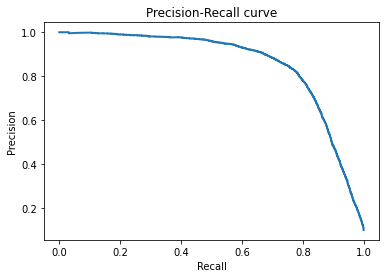

In [50]:
# Код отрисовки Precison-recall кривой
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3) 
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_3)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.savefig("Precision_Recall_curve.png")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Теперь начертим точность и полноту на одной графике:

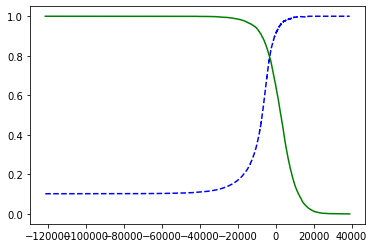

In [41]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_3)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)
def hueta(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Точность")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Полнота")
hueta(precisions, recalls, thresholds)
plt.show()

Рассмотрим пример. Допустим вы хотите точность 90%, тогда после того, как вы взглянете на второй график, станет очевидно, что следует брать порог около -500. Чтобы обеспечить более высокую точность, можно отыскать меньший порог, используя <b>np.argmax()</b>, которая предоставит первый индекс максимального значения, при котором первым значением будет <b>True</b>.


In [42]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

-411.4432659249586


Для выработки прогнозов на обучающем наборе, чтобы не вызывать метод <b>predict()</b>, можно использовать следующий код:


In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(y_train_pred_90 )

[False False False ... False False False]


Для проверки точности и полноты таких прогнозов: 

In [44]:
from sklearn.metrics import  precision_score
precision_score(y_train_3, y_train_pred_90)


0.9000870700914236

In [45]:
from sklearn.metrics import recall_score
recall_score(y_train_3, y_train_pred_90)

0.6744413635622247

Замечательно! мы сделали какую-то неработающую штуку с точностью 90%!
Для создания классификатора любой точности, которую вы сможете себе пожелать, нужно установить достаточно высокий порог и всё. Но помните, высокоточный классификатор не очень useful, ежели его полнота достаточно низкая.

# <strong>ROC кривая</strong>

Ещё одним распространенным инструментом, применяемым с двоичными классификаторами является кривая рабочей характеристики (receiver operating characteristic) - <b>ROC</b>.
Представляет собой отношение доли истинно-положительных классификаций (True Positive Rate, также называется чувствительностью классификации) к доле ложно-положительных классификаций (False Positive Rate, величина (1 - FPR) называется специфичностью алгоритма классификации). 
То есть, как вы можете понять, иными словами кривая ROC изображает чувствительность относительно 1 - специфичность.



Для отрисовки кривой <b>ROC</b>, необходимо определить <b>TPR</b> и <b>FPR</b>, описанные выше. Для этого используем функцию <b>roc_curve()</b>.

После определения нужных параметров, теперь можем начертить график <b>FPR</b> по сравнению  с <b>TPR</b>:

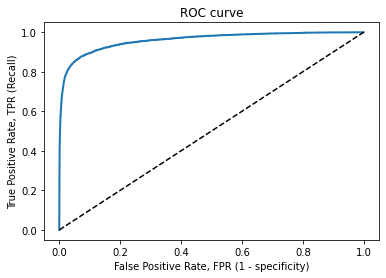

In [46]:
# Код отрисовки ROC-кривой
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3)  
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3) 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

Итак, имеем нарисованную ROC кривую. Здесь тоже очвеидно можно заметить, что чем выше полнота (recall), тем больше получается ложноположительных классифкаций (FPR). Пунктирная линия  - ROC кривая абсолютно случайного классификатора, чем лучше классификатор, тем ближе к верхнему левому углу его прямая.
Из сказанного выше становится очевидно, что для оценки классификаторов, также как и для их сравнения можно использовать площадь под графиком кривой ROC. Такой показатель есть и называется <b>AUC - area under the curve</b>. Очевидно, что чем лучше классификатор, тем ближе к 1 будет значение AUC. В то время как у абсолютно случайного классификатора, это значение будет 0,5. 
Рассчитаем площадь под графиком:

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3, y_scores)

0.9599243001892759

Круто! получили площадь под графиком!

Поскольку между кривыми ROC и кривой соотношения precision recall сходство неоспоримо, то вохможно возникнет вопрос, какую же метрику использовать в определенном случае. 
Поэтому существует следующее правило: когда положительный класс редко встречается или более важны ложноположительные классификации, чем ложноотрицательные, то следует отдавать предпочтение кривой PR. Иначе - кривой ROC. Например, в наше графике ROC и при подсчете AUC мы получили неплохие значения лишь потому, что количество положительных классификаций (троеки) в несколько раз меньше относительно отрицательных классификаций (не троек). В таком случае кривая PR в большей мере дает представление о том, что кдассификатор может быть лучше.

# <strong>RandomForestClassifier</strong>

Всё это время мы использовали классификатор SGDClassifier библиотеки Scikit Learn. Но давайте попробуем обучить другой классификатор и увидеть его график ROC и площадь AUC. 

Опишем основные отличия RandomForestClassifier от SGDClassifier. 
RandomForestClassifier не имеет метода decision_function(), но у него сть аналогичный метод - predict_proba(). Обычно у классификаторов есть какой-то из этих методов или сразу два. Метод predict_proba() возвращает массив, содержащий строку на образец и столбец на класс, содержащий веростность того, что заданный образец принадлежит заданному классу.
Функция roc_curve() ожидает метки и показатели, но вместо этого ей можно предоставить вероятности классов. В примере мы применим вероятность положительного класса в качестве показателя и начертим график.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


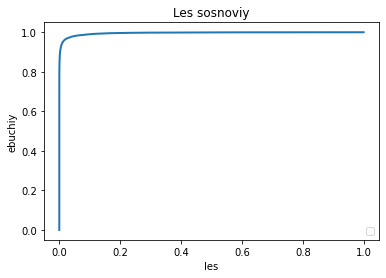

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv =3, method = "predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3, y_scores_forest)
#plt.plot(fpr, tpr, "b:", label = "SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2)
plt.legend(loc="lower right")
plt.xlabel('les')
plt.ylabel('ebuchiy')
plt.title('Les sosnoviy')
plt.savefig("les_nahuy.png")
plt.show()

Сравнивая график ROC кривой двух классификаторов, видно, что кривая ROC RandomForestClassifier намного ближе к левому верхнему углу, чем кривая ROC SGDClassifier. 
В таком случае очевидно также, что показатель AUC тоже будет лучше. 

In [49]:
roc_auc_score(y_train_3, y_scores_forest)

0.995864544068936

Вы также самостоятельно измерить показатели точности и полноты для фореста и сравнить их так как я заебалсся.
Прочитав данную главу о метриках вы научилиь (хотелось бы верить) как обучать двоичные классификаторы, выбирать подходящую метрику для определенной задачи, проводить оценку классификаторов с помощью перекрестной проверки, и узнали много новых метрик. до свидания.